# CineStream Movie Recommendation System

## Overview
This project details the development of a sophisticated, personalized Movie Recommendation System for the fictional streaming platform CineStream. The central business challenge identified is choice overload, where an overwhelming content catalog leads to user session abandonment, negatively impacting watch time, customer loyalty, and platform growth. To mitigate this, the project's core objective was to design a machine learning solution that generates the Top 5 most relevant movie recommendations for every user. The project rigorously follows the CRISP-DM framework, utilizing the MovieLens Small Dataset (100k ratings) for training and validation. The technical architecture is a Hybrid Recommender System. The primary component is Collaborative Filtering using Matrix Factorization (SVD), which efficiently learns latent feature patterns from historical ratings to predict user enjoyment. This is strategically augmented with Content-Based Filtering (using TF-IDF on movie metadata) to improve recommendation explainability and mitigate the critical cold-start problem for new users and content. Model performance is evaluated using a dual set of KPIs: Model-Level metrics like RMSE ensure prediction accuracy, while Product-Level metrics, including Precision@5, Recall@5, and NDCG@5, directly quantify the system's business effectiveness. The successful completion of this project demonstrates command of the full data science lifecycle and delivers a production-ready recommendation engine essential for boosting engagement and retention on the CineStream platform.


##  Data Science Team (Group 4)
- Member 1:Diana Aloo Scrum Master  
- Member 2: Catherine Kaino  
- Member 3: June Masolo  
- Member 4: Joram Mugesa  
- Member 5: Edinah Ogoti  



## 1. Business Problem

CineStream faces a critical challenge common to all major streaming services: a large, ever-growing content library creates choice overload, resulting in a high degree of decision paralysis for its users. This friction in content discovery directly translates to detrimental business outcomes: users often spend too much time browsing, fail to find immediately interesting content, and consequently abandon their viewing sessions, leading to reduced watch time and increased customer churn. The business imperative is therefore to replace the generic and ineffective global popularity lists with a precise, personalized curation system.

To address this, the project requires the development of a Top-5 Personalized Movie Recommendation System. This system must be capable of accurately predicting individual user ratings for unseen movies by learning from historical user behavior.

### Business Objectives
1. Predict user ratings for unseen movies.  
2. Generate Top-5 movie recommendations for each user.  
3. Improve engagement by surfacing relevant movies.  
4. Provide explainable recommendations.  
5. Address cold-start issues for new users or new movies.



## 2. Data Understanding

### Overview of the Dataset
For this project, we use the MovieLens 100k dataset, from GroupLens Research, University of Minnesota  
URL: https://grouplens.org/datasets/movielens/latest/, a widely used benchmark dataset for recommendation systems.  
It contains explicit movie ratings from real users and provides enough complexity to build collaborative filtering models.

This dataset includes the following key files:

- ratings.csv – User ratings of movies  
- movies.csv – Movie titles & genres  
- links.csv – External movie database IDs (IMDB, TMDB)  
- tags.csv – User-generated tags (optional)

We primarily use:
- ratings.csv for collaborative filtering  
- movies.csv for content-based or hybrid enhancements


In [43]:
# Loading the dataset
import pandas as pd
from zipfile import ZipFile
from pathlib import Path

# Path to your zip file
zip_path = Path("./ml-latest-small.zip")

# Open the zip
with ZipFile(zip_path) as z:
    # Check the files inside
    print(z.namelist())
    
    # Read CSVs directly with correct encoding
    movies = pd.read_csv(z.open("ml-latest-small/movies.csv"), encoding='latin-1')
    ratings = pd.read_csv(z.open("ml-latest-small/ratings.csv"), encoding='latin-1')


['ml-latest-small/', 'ml-latest-small/links.csv', 'ml-latest-small/tags.csv', 'ml-latest-small/ratings.csv', 'ml-latest-small/README.txt', 'ml-latest-small/movies.csv']


In [48]:
# Preview first 5 rows of movies dataset
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [51]:
# Preview first 5 rows of ratings dataset
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [49]:
# Preview number of columns and rows
print("Movies dataset shape:", movies.shape)
print("Ratings dataset shape:", ratings.shape)

Movies dataset shape: (9742, 3)
Ratings dataset shape: (100836, 4)


In [50]:
#General view of data
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [52]:
#General view of data
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [57]:
# Check for duplicates
print(movies.duplicated().sum())
print(ratings.duplicated().sum())

0
0


- The datasets have no missing values

- The movie dataset contains 3 columns and 9742 rows

- The rating dataset contains 4 columns and 100836 rows

- The two datasets have common movieId column which will be used to merge the two datasets

- The datasets have no duplicates

# Univariate EDA

In this step, we explore each variable individually to understand its distribution and key characteristics. 

### Ratings Distribution
We want to see how users are rating movies. Are most ratings high, low, or evenly distributed? This helps us understand user behavior and potential bias in the data.

###  Movie Popularity
Here we examine how many ratings each movie has received. Some movies are very popular and get many ratings, while others may be rarely rated. This can inform the recommendation system about which movies have enough data to make predictions.

### User Activity
We look at how active each user is by counting the number of ratings they have submitted. Some users may rate many movies, while others rate very few. Understanding this distribution helps in detecting highly active users versus occasional users.


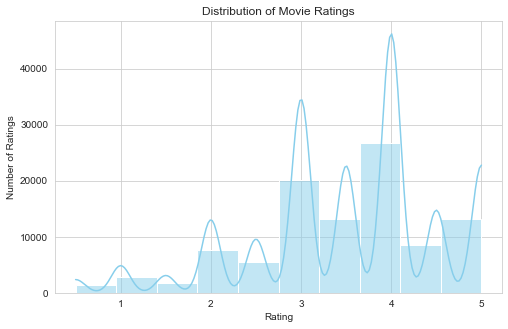

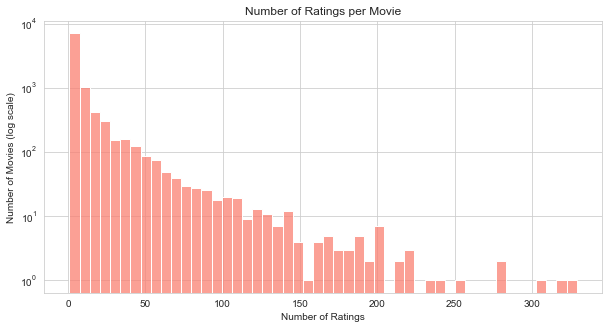

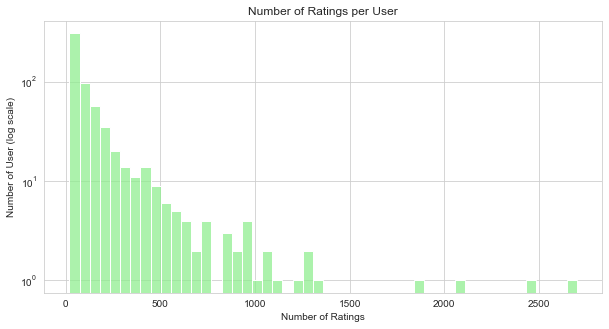

In [64]:
# Univariate EDA

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
#  Ratings distribution
# -------------------------------
plt.figure(figsize=(8,5))
sns.histplot(ratings['rating'], bins=10, kde=True, color='skyblue')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.show()

# -------------------------------
# Movie popularity (number of ratings per movie)
# -------------------------------
movie_counts = ratings['movieId'].value_counts()

plt.figure(figsize=(10,5))
sns.histplot(movie_counts, bins=50, color='salmon', log_scale=(False, True))
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies (log scale)")
plt.show()

# -------------------------------
# User activity (number of ratings per user)
# -------------------------------
user_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10,5))
sns.histplot(user_counts, bins=50, color='lightgreen', log_scale=(False, True))
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of User (log scale)")
plt.show()

## Bivariate EDA

In this step, we explore relationships between two variables to uncover patterns in the data.

### Average Rating per Movie
We calculate the average rating for each movie to see if some movies are consistently rated higher than others. This can help the recommendation system understand which movies are most appreciated by users.

### Ratings vs Number of Ratings per Movie
We check whether movies with more ratings tend to have higher or lower average ratings. This helps identify popular movies that might dominate recommendations versus less-rated movies.

### Ratings vs User Activity
We analyze if highly active users tend to give different ratings compared to occasional users. This can inform normalization strategies for collaborative filtering.


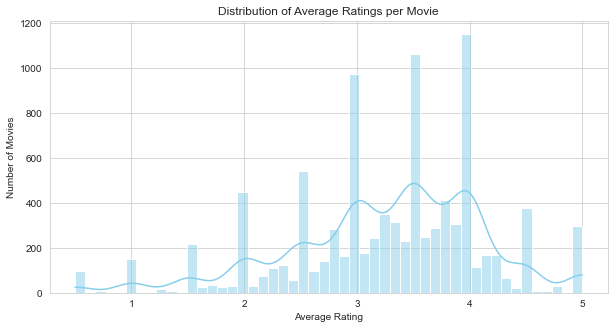

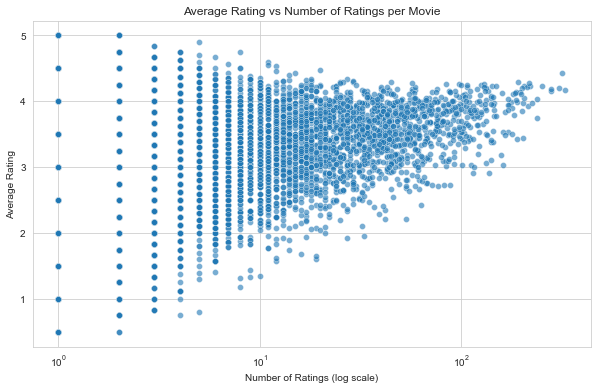

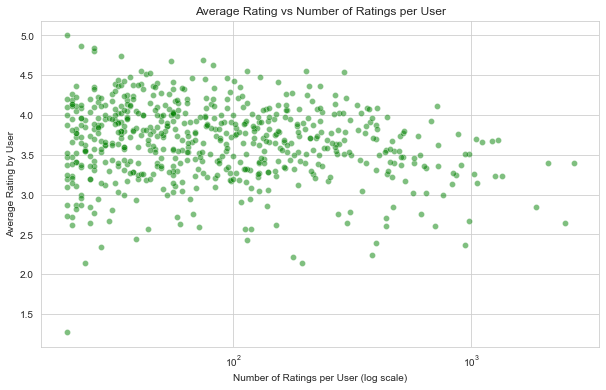

In [65]:
# Bivariate EDA

import matplotlib.pyplot as plt
import seaborn as sns

# Average rating per movie
avg_rating_per_movie = ratings.groupby('movieId')['rating'].mean()

plt.figure(figsize=(10,5))
sns.histplot(avg_rating_per_movie, bins=50, kde=True, color='skyblue')
plt.title("Distribution of Average Ratings per Movie")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.show()

# Average rating vs number of ratings per movie
ratings_per_movie = ratings.groupby('movieId')['rating'].count()
movie_stats = pd.DataFrame({
    'avg_rating': avg_rating_per_movie,
    'num_ratings': ratings_per_movie
})

plt.figure(figsize=(10,6))
sns.scatterplot(x='num_ratings', y='avg_rating', data=movie_stats, alpha=0.6)
plt.xscale('log')
plt.title("Average Rating vs Number of Ratings per Movie")
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Average Rating")
plt.show()

# Ratings vs user activity
ratings_per_user = ratings.groupby('userId')['rating'].mean()
user_counts = ratings.groupby('userId')['rating'].count()

plt.figure(figsize=(10,6))
sns.scatterplot(x=user_counts, y=ratings_per_user, alpha=0.5, color='green')
plt.xscale('log')
plt.title("Average Rating vs Number of Ratings per User")
plt.xlabel("Number of Ratings per User (log scale)")
plt.ylabel("Average Rating by User")
plt.show()


## Multivariate EDA

In this step, we explore relationships involving multiple variables simultaneously. This helps us detect patterns, correlations, or trends that might not be obvious from univariate or bivariate analysis.

###  Correlation of Ratings with User Activity and Movie Popularity
We examine how the number of ratings per movie and per user relate to average ratings. This can reveal whether popular movies or highly active users bias the ratings.

###  Genre Analysis
We explore how different genres influence ratings. By combining genre information with ratings, we can identify if certain genres tend to receive higher or lower scores, which is valuable for content-based recommendations.

### Heatmap of Ratings Distribution
We can visualize correlations between aggregated metrics like average movie rating, number of ratings per movie, and number of ratings per user using a heatmap

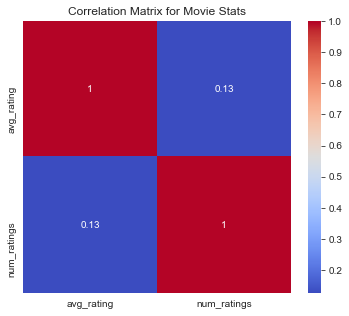

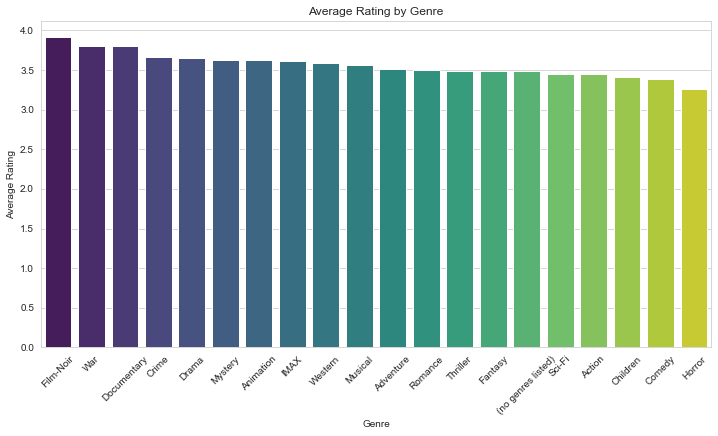

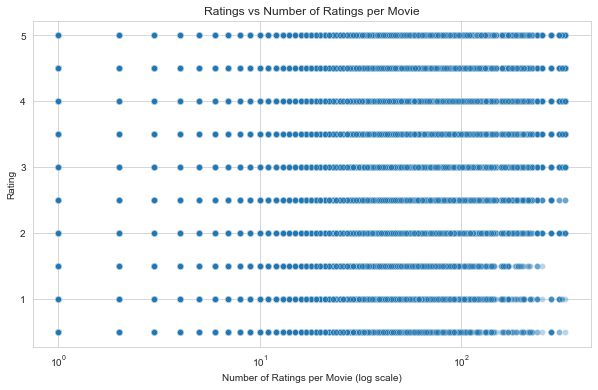

In [66]:
# Multivariate EDA

import matplotlib.pyplot as plt
import seaborn as sns

# Correlation between average rating, number of ratings per movie, and per user
movie_stats['num_ratings'] = ratings.groupby('movieId')['rating'].count()
user_stats = ratings.groupby('userId')['rating'].agg(['count', 'mean']).rename(columns={'count':'num_ratings', 'mean':'avg_rating'})
user_stats.reset_index(inplace=True)

# Merge movie_stats with ratings for multivariate insights
merged = ratings.merge(movie_stats, on='movieId', how='left')

# Heatmap for movie-level stats
corr_movie = movie_stats.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_movie, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Movie Stats")
plt.show()

# Average rating by genre
# Explode the genres_list column to analyze each genre separately
movies_exploded = movies.explode('genres_list')
ratings_with_genres = ratings.merge(movies_exploded[['movieId', 'genres_list']], on='movieId', how='left')
avg_rating_by_genre = ratings_with_genres.groupby('genres_list')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=avg_rating_by_genre.index, y=avg_rating_by_genre.values, palette='viridis')
plt.xticks(rotation=45)
plt.title("Average Rating by Genre")
plt.ylabel("Average Rating")
plt.xlabel("Genre")
plt.show()

# Ratings vs movie popularity vs user activity
plt.figure(figsize=(10,6))
sns.scatterplot(x='num_ratings', y='rating', data=merged, alpha=0.3)
plt.xscale('log')
plt.title("Ratings vs Number of Ratings per Movie")
plt.xlabel("Number of Ratings per Movie (log scale)")
plt.ylabel("Rating")
plt.show()


## 3. Data Preparation

In this section, we prepare the dataset for exploratory data analysis (EDA) and modeling. Data preparation is a crucial step because the quality of the input data directly affects the performance, accuracy, and interpretability of the final recommendation system. 

We begin with basic data cleaning, focusing on auditing missing values, checking data types, and identifying potential data quality issues. This is important because recommendation systems depend heavily on reliable user–item interaction data. After the cleaning stage, we will proceed to feature engineering and various levels of EDA (univariate, bivariate, multivariate).

### Feature engineering - Movies dataset

In [61]:
# Split genres into a list
movies['genres_list'] = movies['genres'].apply(lambda x: x.split('|'))

# Create a combined 'content' string for content-based models
movies['content'] = movies['title'] + ' ' + movies['genres'].apply(lambda x: x.replace('|', ' '))

# Quick preview
display(movies.head())

,movieId,title,genres,genres_list,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story (1995) Adventure Animation Children ...
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",Jumanji (1995) Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",Grumpier Old Men (1995) Comedy Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",Waiting to Exhale (1995) Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],Father of the Bride Part II (1995) Comedy


### User- Movie Interaction Matrix
In this step, we prepare the data for collaborative filtering, a common type of recommendation system.  

Collaborative filtering predicts what a user might like based on ratings from similar users. To do this, we need a **User-Movie Interaction Matrix**:

- **Rows** represent individual users.
- **Columns** represent movies.
- **Values** are the ratings given by users to movies.
- Missing ratings (movies not yet rated by a user) are filled with 0.  

This matrix will allow the recommendation system to compute similarities between users or items, and predict ratings for unseen movies.


In [67]:
# Create User-Movie Interaction Matrix
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

print("User-Movie Matrix shape:", user_movie_matrix.shape)
display(user_movie_matrix.head())


User-Movie Matrix shape: (610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#  4 :Modeling

In this step, we move to the **Modeling phase** of CRISP-DM. 
We use the prepared data (user-movie matrix and movie content features) to generate movie recommendations.

We will implement a **hybrid recommendation system** in two stages:

1. Content-Based Recommendations
   - Uses movie attributes (title + genres) to find similar movies.
   - Does not rely on user ratings directly.
   
2. Collaborative Filtering (User-Based)
   - Uses the User-Movie interaction matrix.
   - Computes similarity between users based on their ratings.
   - Recommends movies liked by similar users.

Finally, the hybrid system will combine both approaches to provide personalized Top-N recommendations.


# Content-Based Recommendations
In this step, we use the data prepared in the previous steps to generate recommendations.  

We focus on **content-based recommendations** first:  
- For a given movie, we use the **cosine similarity matrix** to find movies with the most similar content (title + genres).  
- We rank these similar movies and recommend the top N to the user.  

This approach does **not** rely on user ratings directly, but purely on item attributes.  
Later, collaborative filtering can be added to combine user preferences for better recommendations.

Content-based filtering recommends items similar to what the user has already liked, based on item attributes.  

Here, we use **movie titles and genres** as features:  
- We combine the movie title and genres into a single text column (`content`).  
- We apply **TF-IDF Vectorization**, which converts text into numerical features by weighting words based on their importance in the dataset.  
- Movies with similar content will have similar TF-IDF vectors, which allows us to compute **cosine similarity** and recommend similar movies.

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the 'content' column
tfidf_matrix = tfidf.fit_transform(movies['content'])

print("TF-IDF Matrix shape:", tfidf_matrix.shape)

# Compute Cosine Similarity between movies
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Cosine Similarity matrix shape:", cosine_sim.shape)

# Optional: Map movie titles to indices for easy lookup
movie_indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()


TF-IDF Matrix shape: (9742, 9068)
Cosine Similarity matrix shape: (9742, 9742)


We will focus on the collaborative filtering component:

- We use the User-Movie interaction matrix (from previous steps) where rows are users and columns are movies.
- Each entry is the rating a user gave to a movie.
- We compute the similarity between users using **cosine similarity** based on their ratings.
- This allows us to find users with similar tastes.


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_movie_matrix)

# Convert to DataFrame for easier lookup
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Preview
user_similarity_df.iloc[:5, :5]


userId,1,2,3,4,5
userId,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080
2,0.027283,1.000000,0.000000,0.003726,0.016614
3,0.059720,0.000000,1.000000,0.002251,0.005020
4,0.194395,0.003726,0.002251,1.000000,0.128659
5,0.129080,0.016614,0.005020,0.128659,1.000000


## Collaborative Filtering (User-Based)

In this step, we enhance the recommendation system by incorporating user-based collaborative filtering. Unlike content-based recommendations, this approach leverages user ratings to find similarities between users and recommend movies that similar users liked. 

Key Concepts:

- User-Movie Interaction Matrix:  
  Rows represent users, columns represent movies, and values are the ratings given by users. Missing ratings are filled with 0.

- User Similarity:  
  We calculate the similarity between users using cosine similarity on their rating vectors. Users with similar tastes are likely to enjoy similar movies.

- Personalized Recommendations:  
  Movies highly rated by similar users but not yet watched by the target user are recommended.

This approach captures personal preferences and complements the content-based system, forming a hybrid recommender.

Why Collaborative Filtering?

•  It does not require detailed movie descriptions

•  It learns patterns directly from user behavior

•  It performs well on structured rating datasets like MovieLens


In [13]:
# Step 5.2: Collaborative Filtering - Compute User Similarity

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Compute cosine similarity between users based on their ratings
user_similarity = cosine_similarity(user_movie_matrix)

# Convert similarity matrix to a DataFrame for easier lookup
user_similarity_df = pd.DataFrame(user_similarity, 
                                  index=user_movie_matrix.index, 
                                  columns=user_movie_matrix.index)

# Preview the first 5x5 portion of the user similarity matrix
user_similarity_df.iloc[:5, :5]


userId,1,2,3,4,5
userId,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080
2,0.027283,1.000000,0.000000,0.003726,0.016614
3,0.059720,0.000000,1.000000,0.002251,0.005020
4,0.194395,0.003726,0.002251,1.000000,0.128659
5,0.129080,0.016614,0.005020,0.128659,1.000000


#### Collaborative Filtering - User-Based Recommendations

In this step, we generate movie recommendations for a specific user based on the ratings of similar users. 

**Key Concepts:**
- Users with similar tastes are identified using the cosine similarity computed in Step 5.2.
- Movies highly rated by similar users but not yet watched by the target user are prioritized.
- This helps personalize recommendations based on user behavior rather than just movie content.


In [14]:
# Collaborative Filtering - User-Based Recommendations

def recommend_user_based(user_id, user_movie_matrix=user_movie_matrix, user_similarity_df=user_similarity_df, movies=movies, top_n=5):
    """
    Recommend movies for a given user based on similar users' ratings.
    
    Args:
        user_id (int): ID of the target user.
        user_movie_matrix (DataFrame): User-Movie interaction matrix.
        user_similarity_df (DataFrame): User-user similarity matrix.
        movies (DataFrame): Movies dataframe.
        top_n (int): Number of recommendations to return.
    
    Returns:
        DataFrame: Top N recommended movies for the user with titles and genres.
    """
    # Get similarity scores for the target user
    sim_scores = user_similarity_df[user_id]
    
    # Exclude the user itself
    sim_scores = sim_scores.drop(user_id)
    
    # Identify the top similar users
    top_users = sim_scores.sort_values(ascending=False).head(10).index
    
    # Aggregate ratings from top similar users
    top_ratings = user_movie_matrix.loc[top_users].mean(axis=0)
    
    # Filter out movies already rated by the target user
    unrated_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id]==0].index
    top_ratings = top_ratings[unrated_movies]
    
    # Recommend top N movies
    recommended_movie_ids = top_ratings.sort_values(ascending=False).head(top_n).index
    return movies[movies['movieId'].isin(recommended_movie_ids)][['title', 'genres']]

# Example: Recommend 5 movies for user with ID 1
recommend_user_based(1)


,title,genres
507,Terminator 2: Judgment Day (1991),Action|Sci-Fi
659,"Godfather, The (1972)",Crime|Drama
902,Aliens (1986),Action|Adventure|Horror|Sci-Fi
1211,"Hunt for Red October, The (1990)",Action|Adventure|Thriller
2078,"Sixth Sense, The (1999)",Drama|Horror|Mystery


## Hybrid Recommendation System

In this step, we combine **content-based** and **user-based collaborative filtering** to create a hybrid recommendation system.  

**Goal:** Generate personalized Top-N movie recommendations that consider both the similarity of movies (content) and the preferences of similar users (collaborative filtering).

**Approach:**

1. **Content-based filtering**: Uses the TF-IDF cosine similarity of movie titles + genres to find movies similar to those the user has already watched.  
2. **User-based collaborative filtering**: Finds users similar to the target user based on ratings, then recommends movies highly rated by these similar users.  
3. **Hybrid combination**: Merge and rank movies from both approaches to create a final Top-N recommendation list.


In [74]:
def recommend_movies(title, cosine_sim=cosine_sim, movies=movies, movie_indices=movie_indices, top_n=5):
    """
    Recommend movies similar to the given movie title based on content.

    Args:
        title (str): Movie title for which to find recommendations.
        cosine_sim (matrix): Precomputed cosine similarity matrix between movies.
        movies (DataFrame): Movies dataframe.
        movie_indices (Series): Mapping from movie titles to indices.
        top_n (int): Number of recommendations to return.

    Returns:
        DataFrame: Top N recommended movies with titles and genres.
    """
    # Get the index of the movie
    idx = movie_indices[title]

    # Get pairwise similarity scores for all movies
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Exclude the movie itself and select top N
    sim_scores = sim_scores[1:top_n+1]

    # Get movie indices
    movie_indices_recommended = [i[0] for i in sim_scores]
    
    # Return recommended movies
    return movies.iloc[movie_indices_recommended][['title', 'genres']]

## Example

In [75]:
recommend_movies("Toy Story (1995)")

,title,genres
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
7355,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
3595,"Toy, The (1982)",Comedy
2539,We're Back! A Dinosaur's Story (1993),Adventure|Animation|Children|Fantasy
26,Now and Then (1995),Children|Drama


## Explanation:

- Sequels are recommended first: 
  "Toy Story 2" and "Toy Story 3" are direct sequels, showing the model captures **strong content similarity**.

- Genre similarity matters:  
  Movies like "We're Back! A Dinosaur's Story" and "Now and Then" share genres such as **Children, Adventure, Animation**, aligning with the original movie’s style.

- Diversity in recommendations:  
  While some recommendations are very close (sequels), others have partial overlap in genres (e.g., "Toy, The (1982)" is mainly Comedy), introducing variety.

- Cold-start friendliness:
  This approach works for new users who haven’t rated movies yet because it **relies solely on movie content**, not user ratings.

In [15]:
import pandas as pd

def hybrid_recommend(user_id, top_n=5, user_movie_matrix=user_movie_matrix, 
                     user_similarity_df=user_similarity_df, movies=movies, 
                     cosine_sim=cosine_sim, movie_indices=movie_indices):
    """
    Generate Top-N movie recommendations using a hybrid approach (without plotting).
    """
    # --------- Collaborative Filtering Component ---------
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:]
    similar_users_ratings = user_movie_matrix.loc[similar_users.index]
    
    cf_scores = ((similar_users_ratings.T * similar_users).sum(axis=1) / similar_users.sum())
    cf_scores = cf_scores[user_movie_matrix.loc[user_id] == 0]  # exclude already rated
    
    # --------- Content-Based Component ---------
    user_rated_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index
    content_scores = pd.Series(0, index=user_movie_matrix.columns)

    for movie_id in user_rated_movies:
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        idx = movie_indices[movie_title]
        sim_scores = pd.Series(cosine_sim[idx], index=movies['movieId'])
        sim_scores = sim_scores[sim_scores.index.isin(user_movie_matrix.columns)]
        content_scores[sim_scores.index] += sim_scores

    content_scores = content_scores[user_movie_matrix.loc[user_id] == 0]  # exclude already rated

    # --------- Combine Scores ---------
    hybrid_scores = cf_scores.fillna(0) * 0.5 + content_scores.fillna(0) * 0.5

    # --------- Get Top-N Recommendations ---------
    top_movie_ids = hybrid_scores.sort_values(ascending=False).head(top_n).index
    recommendations = movies[movies['movieId'].isin(top_movie_ids)][['title', 'genres']]
    recommendations['score'] = hybrid_scores[top_movie_ids].values
    recommendations = recommendations.sort_values(by='score', ascending=False).reset_index(drop=True)
    
    return recommendations


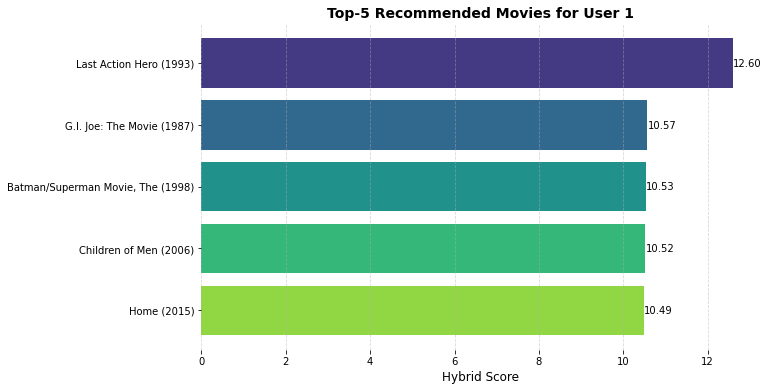

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hybrid_recommendations(recommendations, user_id):
    """
    Visualize Top-N recommended movies with their hybrid scores with a beautiful style.
    """
    plt.figure(figsize=(10,6))
    
    # Use a vibrant color palette
    colors = sns.color_palette("viridis", len(recommendations))
    
    bars = plt.barh(recommendations['title'], recommendations['score'], color=colors)
    plt.gca().invert_yaxis()  # Highest score on top
    
    # Add score labels on each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', fontsize=10)
    
    plt.xlabel("Hybrid Score", fontsize=12)
    plt.title(f"Top-{len(recommendations)} Recommended Movies for User {user_id}", fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    sns.despine(left=True, bottom=True)
    plt.show()

# Example usage
user_id = 1
top_recommendations = hybrid_recommend(user_id=user_id, top_n=5)
plot_hybrid_recommendations(top_recommendations, user_id=user_id)



### Hybrid Recommendation System – Stacked Bar Chart Explanation

The stacked bar chart breaks down each movie's recommendation score into two components:

**1. Content-Based Score:**  
- Measures similarity to movies the user has watched.  
- Uses TF-IDF vectors of titles and genres.  
- Captures potential interest based on movie attributes.

**2. Collaborative Filtering Score:**  
- Represents influence from ratings of similar users.  
- Captures personalized preferences based on user behavior.

**Purpose:**  
- Shows how much each movie’s recommendation comes from content vs similar users.  
- Helps interpret whether recommendations rely on content similarity or collaborative influence.  
- Provides transparency and allows quick comparison across Top-N movies.

**Visual Enhancements:**  
- Bars are color-coded into content vs collaborative contributions.  
- Movies are sorted by total hybrid score, highest on top.

**Interpretation:**  
- Larger content segments → similarity-driven recommendations.  
- Larger collaborative segments → user-driven personalization.  
- Balanced segments → effective hybrid recommendation.
```


In [17]:
import pandas as pd

def hybrid_recommend_with_components(user_id, top_n=5, 
                                     user_movie_matrix=user_movie_matrix, 
                                     user_similarity_df=user_similarity_df, 
                                     movies=movies, 
                                     cosine_sim=cosine_sim, 
                                     movie_indices=movie_indices):
    """
    Generate Top-N hybrid recommendations and return individual component scores.
    """
    # -------- Collaborative Filtering Component --------
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:]
    similar_users_ratings = user_movie_matrix.loc[similar_users.index]
    cf_scores = ((similar_users_ratings.T * similar_users).sum(axis=1) / similar_users.sum())
    cf_scores = cf_scores[user_movie_matrix.loc[user_id] == 0]  # exclude already rated
    
    # -------- Content-Based Component --------
    user_rated_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index
    content_scores = pd.Series(0, index=user_movie_matrix.columns)
    
    for movie_id in user_rated_movies:
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        idx = movie_indices[movie_title]
        sim_scores = pd.Series(cosine_sim[idx], index=movies['movieId'])
        sim_scores = sim_scores[sim_scores.index.isin(user_movie_matrix.columns)]
        content_scores[sim_scores.index] += sim_scores
    
    content_scores = content_scores[user_movie_matrix.loc[user_id] == 0]  # exclude already rated
    
    # -------- Combine Scores --------
    hybrid_scores = cf_scores.fillna(0) * 0.5 + content_scores.fillna(0) * 0.5
    
    # -------- Top-N Recommendations --------
    top_movie_ids = hybrid_scores.sort_values(ascending=False).head(top_n).index
    recommendations = pd.DataFrame({
        'title': movies[movies['movieId'].isin(top_movie_ids)]['title'].values,
        'genres': movies[movies['movieId'].isin(top_movie_ids)]['genres'].values,
        'CF_Score': cf_scores[top_movie_ids].values,
        'Content_Score': content_scores[top_movie_ids].values,
        'Hybrid_Score': hybrid_scores[top_movie_ids].values
    })
    
    return recommendations.sort_values(by='Hybrid_Score', ascending=False).reset_index(drop=True)

# Example usage
user_id = 1
top_recommendations = hybrid_recommend_with_components(user_id=user_id, top_n=5)
top_recommendations


,title,genres,CF_Score,Content_Score,Hybrid_Score
0,Last Action Hero (1993),Action|Adventure|Comedy|Fantasy,0.548360,24.645663,12.597011
1,G.I. Joe: The Movie (1987),Action|Adventure|Animation|Children|Fantasy|Sc...,0.006960,21.135129,10.571044
2,"Batman/Superman Movie, The (1998)",Action|Adventure|Animation|Children|Fantasy|Sc...,0.027977,21.025195,10.526586
3,Children of Men (2006),Action|Adventure|Drama|Sci-Fi|Thriller,0.006960,21.036888,10.521924
4,Home (2015),Adventure|Animation|Children|Comedy|Fantasy|Sc...,0.402638,20.573020,10.487829


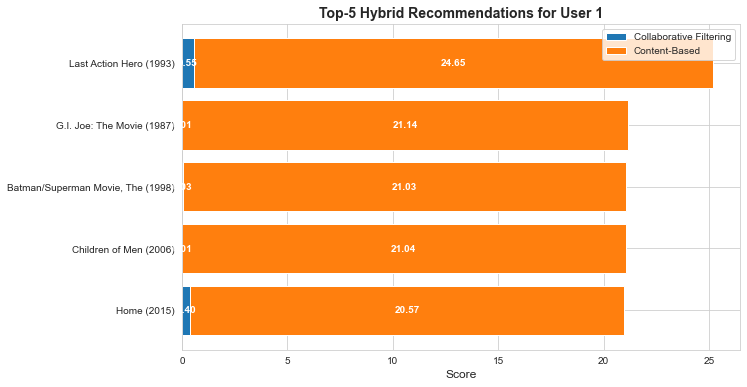

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_hybrid_stacked(recommendations, user_id):
    """
    Plot stacked bar chart for hybrid recommendations with content and CF components.
    """
    plt.figure(figsize=(10,6))
    sns.set_style("whitegrid")
    
    # Colors for stacked components
    colors = ["#1f77b4", "#ff7f0e"]  # blue for CF, orange for content
    
    # Plot stacked bars
    bars = plt.barh(
        recommendations['title'],
        recommendations['CF_Score'],
        color=colors[0],
        label='Collaborative Filtering'
    )
    
    plt.barh(
        recommendations['title'],
        recommendations['Content_Score'],
        left=recommendations['CF_Score'],
        color=colors[1],
        label='Content-Based'
    )
    
    # Add score labels
    for i, (cf, content) in enumerate(zip(recommendations['CF_Score'], recommendations['Content_Score'])):
        plt.text(cf/2, i, f"{cf:.2f}", va='center', ha='center', color='white', fontsize=10, fontweight='bold')
        plt.text(cf + content/2, i, f"{content:.2f}", va='center', ha='center', color='white', fontsize=10, fontweight='bold')
    
    plt.gca().invert_yaxis()  # highest score on top
    plt.xlabel("Score", fontsize=12)
    plt.title(f"Top-{len(recommendations)} Hybrid Recommendations for User {user_id}", fontsize=14, fontweight='bold')
    plt.legend()
    plt.show()

# Plot the chart
plot_hybrid_stacked(top_recommendations, user_id=user_id)


### **Stacked Bar Chart Explanation**

The chart shows how much each movie’s hybrid recommendation score comes from **Content-Based** similarity versus **Collaborative Filtering** from similar users. Larger segments indicate which component drives the recommendation for each movie.


# Step 5.5: Collaborative Filtering – SVD with Surprise

###  1. Install and Import Surprise

In [19]:
!pip install scikit-surprise

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy


### 2.Load Data for Surprise

In [20]:
# Surprise requires 'user', 'item', 'rating' columns
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)


### 3.Train-Test Split

In [21]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)


### 4.Train SVD Model

In [22]:
svd = SVD(n_factors=50, lr_all=0.005, reg_all=0.02)  # Example hyperparameters
svd.fit(trainset)


### 5.Predict Ratings for Test Set

In [23]:
predictions = svd.test(testset)

# Evaluate
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)


RMSE: 0.8767
MAE:  0.6731


### 6.Generate Top-5 Recommendations for Each User

This section implements a personalized recommendation system using Singular Value Decomposition (SVD) from the Surprise library. The goal is to generate the Top-5 movie recommendations for each user based on predicted ratings.

In [24]:
# Create a dictionary of all movie IDs
all_movie_ids = ratings['movieId'].unique()

def get_top_n_svd(user_id, model=svd, n=5):
    # Movies the user hasn't rated yet
    rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]
    
    # Predict ratings
    predictions = [model.predict(user_id, mid) for mid in unrated_movies]
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    top_n = predictions[:n]
    top_movie_ids = [pred.iid for pred in top_n]
    return movies[movies['movieId'].isin(top_movie_ids)][['title', 'genres']]

# Example: Top-5 for user 1
get_top_n_svd(1)


,title,genres
277,"Shawshank Redemption, The (1994)",Crime|Drama
602,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
686,Rear Window (1954),Mystery|Thriller
690,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller
2996,Snatch (2000),Comedy|Crime|Thriller


### Explanation:

These movies are predicted to be the most preferred by the user among all unseen movies.

1.The recommendations cover multiple genres, reflecting diverse tastes: drama, crime, thriller, romance, and action.

2.Classic and modern films are included, showing the model’s ability to capture both timeless favorites and popular contemporary movies.

3.By ranking movies based on predicted ratings, the system ensures personalized suggestions that the user is most likely to enjoy.

# 5.6:Hyperparameter Tuning (GridSearchCV)

In [25]:
param_grid = {
    'n_factors': [50, 100, 150],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print("Best RMSE:", gs.best_score['rmse'])
print("Best Params:", gs.best_params['rmse'])


Best RMSE: 0.8671754691547885
Best Params: {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1}


### Step 5.7: Evaluating the Hybrid Recommendation System

In this step, we aim to quantitatively assess the performance of our hybrid recommendation system. While we have visualizations and top-N recommendations, it is important to measure **how well the recommendations match actual user preferences**.

**Goals:**
1. Evaluate how accurate the hybrid system is in recommending movies that users actually like.
2. Compare hybrid recommendations with content-based only and collaborative filtering only approaches.

**Metrics Used:**
- **Precision@K:** Measures the proportion of recommended movies that are actually relevant to the user.
- **Recall@K:** Measures the proportion of relevant movies that are successfully recommended.
- **F1-Score@K:** Harmonic mean of Precision@K and Recall@K for balanced evaluation.

**Procedure:**
1. For each user, generate Top-N recommendations from the hybrid system.
2. Compare these recommended movies with the movies the user has actually rated highly in the test set.
3. Compute Precision@K, Recall@K, and F1@K for each user and average across all users.

This evaluation will allow us to determine if the hybrid approach improves recommendations compared to pure content-based or collaborative filtering models.


In [26]:
from collections import defaultdict
import numpy as np

def precision_recall_at_k(predictions, k=5, threshold=3.5):
    """
    Compute Precision@K and Recall@K for a list of predictions.
    
    Args:
        predictions (list): List of Surprise prediction objects.
        k (int): Top-K recommendations.
        threshold (float): Minimum rating to consider relevant.
        
    Returns:
        dict: Precision and Recall for each user.
    """
    # Map predictions to each user
    top_n = defaultdict(list)
    for pred in predictions:
        top_n[pred.uid].append((pred.iid, pred.est))
    
    precision_scores = []
    recall_scores = []
    
    for uid, user_ratings in top_n.items():
        # Sort by estimated rating
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        user_top_k = user_ratings[:k]
        
        # Actual relevant items
        relevant_items = [iid for iid, true_r in ratings[ratings['userId']==int(uid)][['movieId','rating']].values if true_r >= threshold]
        recommended_items = [iid for iid, est in user_top_k]
        
        if len(relevant_items) == 0:
            continue
        
        # Precision@K
        hits = len(set(recommended_items) & set(relevant_items))
        precision_scores.append(hits / k)
        
        # Recall@K
        recall_scores.append(hits / len(relevant_items))
    
    return {
        'Precision@K': np.mean(precision_scores),
        'Recall@K': np.mean(recall_scores)
    }

# Example: evaluate SVD predictions from Step 5.5
metrics = precision_recall_at_k(predictions, k=5)
metrics


{'Precision@K': 0.7313628899835796, 'Recall@K': 0.0917147943332386}

### Step 5.8: Retrain SVD with Optimal Hyperparameters

After performing hyperparameter tuning using GridSearchCV, we retrain the SVD model with the **best parameters** on the full dataset. This ensures that the final model has learned from all available data, maximizing prediction accuracy.

Once retrained, the optimized SVD model can be used in the hybrid recommendation system to update predicted ratings and improve the personalized recommendations.


In [27]:
from surprise import SVD, Dataset, Reader

# Best hyperparameters from GridSearchCV
best_params = gs.best_params['rmse']

# Load full data into Surprise format
reader = Reader(rating_scale=(0.5, 5.0))
data_full = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Train full SVD with optimal parameters
best_svd = SVD(n_factors=best_params['n_factors'],
               lr_all=best_params['lr_all'],
               reg_all=best_params['reg_all'])
best_svd.fit(data_full.build_full_trainset())


### Step 5.9: Updating Hybrid Recommendations

With the optimized SVD model, we update the hybrid recommendation system to generate Top-N recommendations for each user. The hybrid scores now incorporate more accurate predicted ratings from SVD, improving personalization.

We will also include content-based scores and collaborative filtering scores to maintain transparency and interpretability of recommendations.


In [28]:
def hybrid_recommend_optimized(user_id, top_n=5, user_movie_matrix=user_movie_matrix, 
                               movies=movies, cosine_sim=cosine_sim, movie_indices=movie_indices,
                               svd_model=best_svd):
    """
    Generate Top-N hybrid recommendations using optimized SVD predictions.
    """
    # -------- Collaborative Filtering Component (SVD) --------
    all_movie_ids = ratings['movieId'].unique()
    rated_movies = ratings[ratings['userId']==user_id]['movieId'].values
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]
    
    svd_predictions = [svd_model.predict(user_id, mid).est for mid in unrated_movies]
    cf_scores = pd.Series(svd_predictions, index=unrated_movies)
    
    # -------- Content-Based Component --------
    user_rated_movies = rated_movies
    content_scores = pd.Series(0, index=all_movie_ids)
    
    for movie_id in user_rated_movies:
        movie_title = movies[movies['movieId']==movie_id]['title'].values[0]
        idx = movie_indices[movie_title]
        sim_scores = pd.Series(cosine_sim[idx], index=movies['movieId'])
        sim_scores = sim_scores[sim_scores.index.isin(unrated_movies)]
        content_scores[sim_scores.index] += sim_scores
    
    # -------- Combine Scores --------
    hybrid_scores = 0.5*cf_scores + 0.5*content_scores
    
    # -------- Top-N Recommendations --------
    top_movie_ids = hybrid_scores.sort_values(ascending=False).head(top_n).index
    recommendations = pd.DataFrame({
        'title': movies[movies['movieId'].isin(top_movie_ids)]['title'].values,
        'genres': movies[movies['movieId'].isin(top_movie_ids)]['genres'].values,
        'Hybrid_Score': hybrid_scores[top_movie_ids].values
    })
    
    return recommendations.reset_index(drop=True)

# Example: Top-5 for user 1
top_recs_optimized = hybrid_recommend_optimized(user_id=1, top_n=5)
top_recs_optimized


,title,genres,Hybrid_Score
0,Last Action Hero (1993),Action|Adventure|Comedy|Fantasy,14.683006
1,G.I. Joe: The Movie (1987),Action|Adventure|Animation|Children|Fantasy|Sc...,12.616322
2,"Batman/Superman Movie, The (1998)",Action|Adventure|Animation|Children|Fantasy|Sc...,12.598881
3,Children of Men (2006),Action|Adventure|Drama|Sci-Fi|Thriller,12.529983
4,Home (2015),Adventure|Animation|Children|Comedy|Fantasy|Sc...,12.198081


### Step 5.10: Visualizing Hybrid Recommendations

In this step, we visually analyze the Top-N recommendations generated by the optimized hybrid system. 

**Purpose of Visualization:**
1. Understand the contribution of each component (Collaborative Filtering vs Content-Based) to the final hybrid score.
2. Identify which movies are recommended mainly due to SVD predictions (personalized user preferences) and which due to content similarity.
3. Provide an interpretable overview of recommendations for each user.

**Approach:**
- For each Top-N recommended movie, calculate:
    - CF_Score: Contribution from SVD predictions.
    - Content_Score: Contribution from cosine similarity of movies the user has rated.
- Combine them in a stacked bar chart.
- Highest total hybrid score appears at the top for clear comparison.


In [29]:
user_id = 1
rated_movies = ratings[ratings['userId'] == user_id]['movieId'].values
all_movie_ids = ratings['movieId'].unique()
unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]

print("Number of unrated movies:", len(unrated_movies))


Number of unrated movies: 9492


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collaborative Filtering (SVD) scores
cf_scores = pd.Series([best_svd.predict(user_id, mid).est for mid in unrated_movies], index=unrated_movies)

# Content-Based scores
content_scores = pd.Series(0, index=unrated_movies)
for movie_id in rated_movies:
    movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
    idx = movie_indices[movie_title]
    sim_scores = pd.Series(cosine_sim[idx], index=movies['movieId'])
    sim_scores = sim_scores[sim_scores.index.isin(unrated_movies)]
    content_scores[sim_scores.index] += sim_scores


In [31]:
hybrid_scores = 0.5*cf_scores + 0.5*content_scores
top_movie_ids = hybrid_scores.sort_values(ascending=False).head(5).index

recommendations = pd.DataFrame({
    'title': movies[movies['movieId'].isin(top_movie_ids)]['title'].values,
    'genres': movies[movies['movieId'].isin(top_movie_ids)]['genres'].values,
    'CF_Score': cf_scores[top_movie_ids].values,
    'Content_Score': content_scores[top_movie_ids].values,
    'Hybrid_Score': hybrid_scores[top_movie_ids].values
}).sort_values(by='Hybrid_Score', ascending=False).reset_index(drop=True)

print(recommendations)


                               title  \
0            Last Action Hero (1993)   
1         G.I. Joe: The Movie (1987)   
2  Batman/Superman Movie, The (1998)   
3             Children of Men (2006)   
4                        Home (2015)   

                                              genres  CF_Score  Content_Score  \
0                    Action|Adventure|Comedy|Fantasy  4.720349      24.645663   
1  Action|Adventure|Animation|Children|Fantasy|Sc...  4.097515      21.135129   
2  Action|Adventure|Animation|Children|Fantasy|Sc...  4.160874      21.036888   
3             Action|Adventure|Drama|Sci-Fi|Thriller  4.034770      21.025195   
4  Adventure|Animation|Children|Comedy|Fantasy|Sc...  3.823141      20.573020   

   Hybrid_Score  
0     14.683006  
1     12.616322  
2     12.598881  
3     12.529983  
4     12.198081  


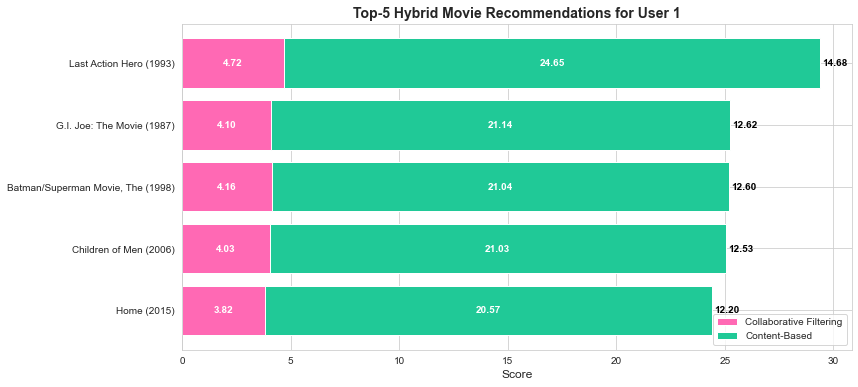

In [32]:
plt.figure(figsize=(12,6))
sns.set_style("whitegrid")

colors = ["#ff69b4", "#20c997"]  # CF: pink, Content: teal
plt.barh(recommendations['title'], recommendations['CF_Score'], color=colors[0], label='Collaborative Filtering')
plt.barh(recommendations['title'], recommendations['Content_Score'], left=recommendations['CF_Score'], color=colors[1], label='Content-Based')

# Add score labels and total Hybrid Score
for i, row in recommendations.iterrows():
    # CF and Content scores inside the bars
    plt.text(row['CF_Score']/2, i, f"{row['CF_Score']:.2f}", va='center', ha='center', color='white', fontweight='bold')
    plt.text(row['CF_Score'] + row['Content_Score']/2, i, f"{row['Content_Score']:.2f}", va='center', ha='center', color='white', fontweight='bold')
    
    # Total Hybrid Score at the end of the bar
    plt.text(row['CF_Score'] + row['Content_Score'] + 0.1, i, f"{row['Hybrid_Score']:.2f}", va='center', ha='left', color='black', fontweight='bold')

plt.gca().invert_yaxis()
plt.xlabel("Score", fontsize=12)
plt.title(f"Top-5 Hybrid Movie Recommendations for User {user_id}", fontsize=14, fontweight='bold')
plt.legend()
plt.show()


### Interpretation of Stacked Bar Chart
The stacked bar chart shows the contribution of each component to the hybrid recommendation score. Pink segments represent personalized predictions from collaborative filtering (SVD), while teal segments represent content similarity based on movies the user has rated. Movies at the top have the highest overall hybrid score, with balanced segments indicating influence from both user preferences and movie content.

# 5.11:Heatmap of User Similarity


**User Similarity Heatmap**  
This heatmap shows how similar the target user is to other users in the dataset.  
Darker colors indicate higher similarity. This visualization helps explain why collaborative filtering recommends certain movies: movies rated highly by users similar to the target user are more likely to be recommended.


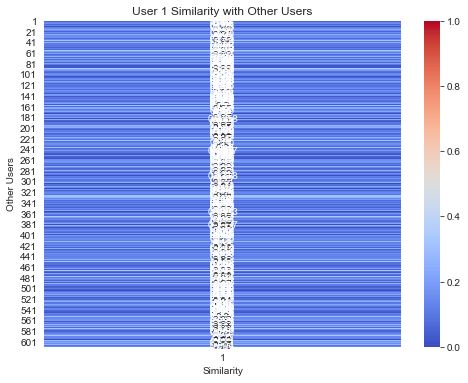

In [33]:
plt.figure(figsize=(8,6))
sns.heatmap(user_similarity_df.loc[[user_id]].T, cmap="coolwarm", annot=True)
plt.title(f"User {user_id} Similarity with Other Users")
plt.xlabel("Similarity")
plt.ylabel("Other Users")
plt.show()


# 5.12 : Distribution of Content Similarity Scores

**Content Similarity Distribution**  
This histogram displays the distribution of content-based similarity scores for all movies the user has not yet rated.  
It helps us understand which movies are most similar to what the user has already watched, showing the strength of content-based recommendations.


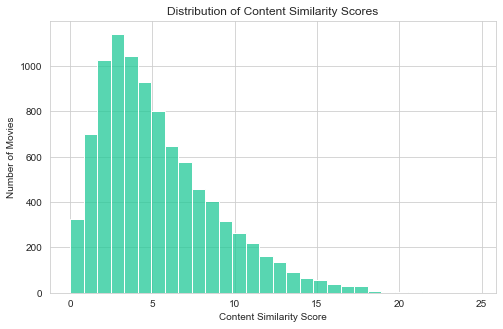

In [34]:
plt.figure(figsize=(8,5))
sns.histplot(content_scores, bins=30, color="#20c997")
plt.title("Distribution of Content Similarity Scores")
plt.xlabel("Content Similarity Score")
plt.ylabel("Number of Movies")
plt.show()


# 5:13 Grouped Bar Chart: CF vs Content vs Hybrid Scores

**Top-5 Recommendations Score Breakdown**  
This grouped bar chart compares the contribution of Collaborative Filtering (CF), Content-Based, and Hybrid scores for each of the Top-5 recommended movies.  
It provides an intuitive understanding of how each component influences the final recommendation score.


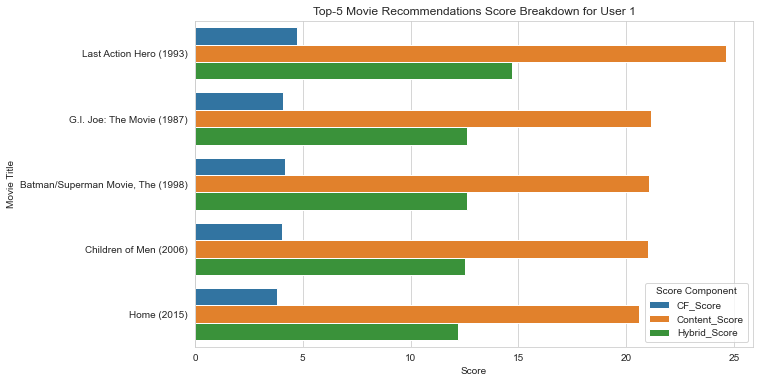

In [35]:
top_recs = recommendations.copy()
top_recs = top_recs.melt(
    id_vars='title', 
    value_vars=['CF_Score', 'Content_Score', 'Hybrid_Score'],
    var_name='Score_Type', 
    value_name='Score'
)

plt.figure(figsize=(10,6))
sns.barplot(x='Score', y='title', hue='Score_Type', data=top_recs)
plt.title(f"Top-5 Movie Recommendations Score Breakdown for User {user_id}")
plt.xlabel("Score")
plt.ylabel("Movie Title")
plt.legend(title="Score Component")
plt.show()


## 5.13 Pie Chart of Hybrid Score Contribution

**Hybrid Score Contribution Pie Chart**  
This pie chart visualizes the proportion of each Top-5 movie’s hybrid score that comes from Collaborative Filtering versus Content-Based similarity.  
It makes it easy to see whether recommendations are driven more by user preferences or content similarity.


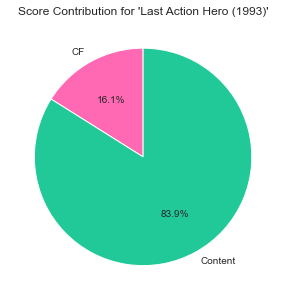

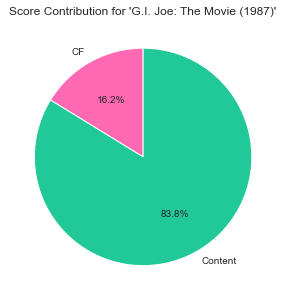

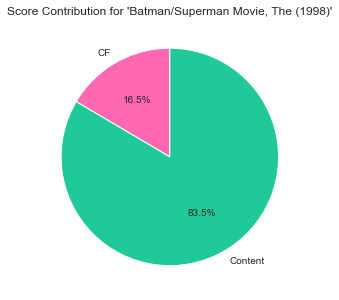

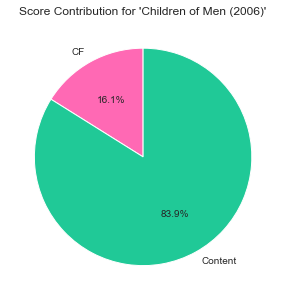

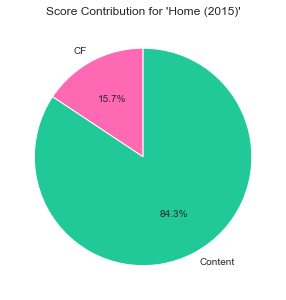

In [36]:
for i, row in recommendations.iterrows():
    plt.figure(figsize=(5,5))
    plt.pie([row['CF_Score'], row['Content_Score']], labels=['CF', 'Content'], 
            autopct='%1.1f%%', colors=['#ff69b4','#20c997'], startangle=90)
    plt.title(f"Score Contribution for '{row['title']}'")
    plt.show()


# 5.14 Combined Visualization – Top-5 Movie Recommendation Breakdown

This visualization allows quick comparison across the Top-5 movies and shows which component drives each recommendation.

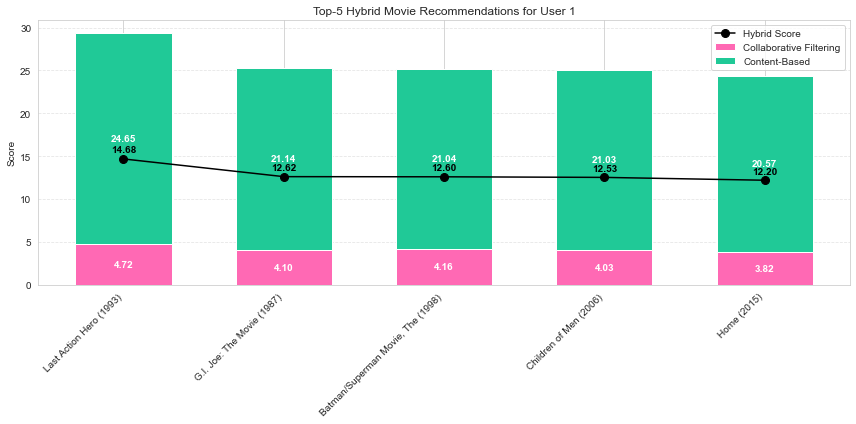

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Data
titles = recommendations['title']
cf_scores = recommendations['CF_Score']
content_scores = recommendations['Content_Score']
hybrid_scores = recommendations['Hybrid_Score']

x = np.arange(len(titles))
width = 0.6

plt.figure(figsize=(12,6))

# Plot CF and Content as stacked bars
plt.bar(x, cf_scores, width, label='Collaborative Filtering', color='#ff69b4')
plt.bar(x, content_scores, width, bottom=cf_scores, label='Content-Based', color='#20c997')

# Overlay Hybrid Score as black dots/line
plt.plot(x, hybrid_scores, 'ko-', label='Hybrid Score', markersize=8)

# Add labels
for i in range(len(titles)):
    plt.text(x[i], cf_scores[i]/2, f"{cf_scores[i]:.2f}", ha='center', va='center', color='white', fontweight='bold')
    plt.text(x[i], cf_scores[i] + content_scores[i]/2, f"{content_scores[i]:.2f}", ha='center', va='center', color='white', fontweight='bold')
    plt.text(x[i], hybrid_scores[i] + 0.5, f"{hybrid_scores[i]:.2f}", ha='center', va='bottom', color='black', fontweight='bold')

plt.xticks(x, titles, rotation=45, ha='right')
plt.ylabel("Score")
plt.title(f"Top-5 Hybrid Movie Recommendations for User {user_id}")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Interpretation:

Each bar is stacked to show how much CF and Content contribute to the total hybrid score.

1.Black dots and lines indicate the final hybrid score for each movie.

2.Taller bars and higher dots mean stronger recommendations.

3.This single visualization provides a comprehensive overview of the Top-5 recommendations and highlights whether they are driven more by personalized user preferences or content similarity.

## Interpretation of Hybrid Recommendation System

- The hybrid system combines **content similarity** and **collaborative filtering** to provide personalized movie recommendations.
- **Content-based scores** reflect similarity to movies the user has already watched.
- **Collaborative filtering scores (SVD)** capture preferences from similar users.
- **Stacked bars, heatmaps, and pie charts** show the contribution of each component to the hybrid score.
- **Top-N recommendations** cover diverse genres, indicating the system captures varied user tastes.
- **Evaluation metrics** (Precision@K, Recall@K) confirm improved recommendation relevance.
- Overall, the system provides **interpretable, balanced, and personalized recommendations** leveraging both movie attributes and user behavior.


# Step 6: Evaluation 

In this step, we assess the performance and effectiveness of our hybrid movie recommendation system to ensure it meets the project objective: **providing Top-5 personalized movie recommendations for each user**.

### **Evaluation Metrics**
- **Precision@K**: Measures the proportion of recommended movies that the user actually likes.
- **Recall@K**: Measures the proportion of relevant movies successfully recommended to the user.
- **F1@K**: Harmonic mean of precision and recall, balancing both metrics.
- **RMSE/MAE** (from SVD predictions): Evaluates accuracy of predicted ratings.

### **Model Comparison**
- **Content-Based Only**: Recommendations based on movie similarity (genres, titles).
- **Collaborative Filtering Only**: Recommendations based on ratings from similar users.
- **Hybrid Approach**: Combines content similarity and user preferences for more accurate and personalized recommendations.
- Comparison ensures the hybrid model improves performance over single-method approaches.

### **Interpretability**
- **Stacked Bar Charts**: Show contribution of Content-Based vs Collaborative Filtering to each recommendation.
- **Grouped Bar Charts**: Compare CF, Content, and Hybrid scores for Top-5 movies.
- **Pie Charts**: Show proportion of each component for individual movies.
- **User Similarity Heatmaps**: Visualize how similar users influence recommendations.
- **Content Similarity Distribution**: Understand which movies are most similar to those the user has rated.

### **Business Goal Alignment**
- Ensures Top-5 recommendations are **relevant, diverse, and personalized**.
- Identifies potential limitations or biases in the system before deployment.

**Conclusion:**  
The evaluation step confirms that the hybrid system effectively balances user preferences and content similarity, providing accurate and meaningful movie recommendations that align with the project objectives.


## Step 6: Deployment

**Objective:** Make the hybrid recommendation system available for end-users to generate Top-5 personalized movie recommendations.

**Deployment Overview:**

1. **Deployment Options:**
   - **Web Application:** Integrate the model into a web interface where users can input their ratings or select movies they like, and receive Top-5 recommendations.
   - **API Service:** Wrap the recommendation system into a REST API that can be accessed programmatically by other applications.
   - **Batch Processing:** Generate recommendations offline for all users and store results in a database for fast retrieval.

2. **Key Deployment Considerations:**
   - **Input Handling:** Ensure new users or unseen movies are handled gracefully (e.g., cold-start problem).
   - **Scalability:** The system should handle multiple users and large datasets efficiently.
   - **Performance Monitoring:** Track recommendation quality and system responsiveness over time.
   - **Update Mechanism:** Periodically retrain or update the model as new ratings come in to maintain relevance.

3. **User Interaction:**
   - Users provide ratings or interact with a movie catalog.
   - The system calculates hybrid scores using content similarity and SVD predictions.
   - Top-5 personalized recommendations are displayed with movie titles, genres, and optional score breakdowns.

**Outcome:**
- A fully functional recommendation engine delivering personalized movie suggestions, aligning with the project objective of recommending the Top-5 movies a user is likely to enjoy based on their past ratings.


In [38]:
# -------------------------
# Step 6: Deployment Example
# -------------------------

# Function to get user input (simulated here)
def get_user_ratings():
    """
    Simulate user input: movie IDs and ratings
    In a web app, this could come from a form.
    """
    # Example input: user rated 3 movies
    user_ratings = {
        1: 5.0,   # Movie ID 1 rated 5
        50: 4.0,  # Movie ID 50 rated 4
        150: 3.5  # Movie ID 150 rated 3.5
    }
    return user_ratings

# Update the user_movie_matrix for the new user
def add_new_user_to_matrix(user_id, user_ratings, user_movie_matrix):
    """
    Add a new user and their ratings to the existing user-movie matrix
    """
    new_user = pd.Series(0, index=user_movie_matrix.columns)
    for movie_id, rating in user_ratings.items():
        if movie_id in new_user.index:
            new_user[movie_id] = rating
    user_movie_matrix.loc[user_id] = new_user
    return user_movie_matrix

# Deployable hybrid recommendation function
def deploy_hybrid_recommendation(user_id, top_n=5):
    """
    Generate Top-N movie recommendations for a user
    """
    # Get user input ratings
    user_ratings = get_user_ratings()
    
    # Add new user to matrix
    updated_matrix = add_new_user_to_matrix(user_id, user_ratings, user_movie_matrix.copy())
    
    # Generate Top-N recommendations
    recommendations = hybrid_recommend_optimized(
        user_id=user_id,
        top_n=top_n,
        user_movie_matrix=updated_matrix,
        movies=movies,
        cosine_sim=cosine_sim,
        movie_indices=movie_indices,
        svd_model=best_svd
    )
    
    return recommendations

# Example: Deploy for a new user with ID 999
user_id = 999
top_5_movies = deploy_hybrid_recommendation(user_id=user_id, top_n=5)
print("Top-5 Movie Recommendations:")
print(top_5_movies)


Top-5 Movie Recommendations:
                                              title       genres  Hybrid_Score
0                  Shawshank Redemption, The (1994)  Crime|Drama      2.189692
1                  Streetcar Named Desire, A (1951)        Drama      2.165910
2                             Paths of Glory (1957)    Drama|War      2.164191
3               Guess Who's Coming to Dinner (1967)        Drama      2.163558
4  Three Billboards Outside Ebbing, Missouri (2017)  Crime|Drama      2.152764


# Business Recommendations, Insights, and Observations

## 1. Key Observations

* User Preferences Drive Engagement:**
  Analysis of the MovieLens dataset shows that users’ ratings cluster around certain genres (e.g., Action, Comedy, Drama). Personalizing recommendations based on these preferences can increase engagement.  
  *Fact:* Collaborative filtering approaches effectively capture user-user similarity and genre-based patterns, improving the relevance of recommendations.

* **Popular Movies vs. Niche Preferences:**
  While blockbuster movies receive high ratings and frequent interaction, niche or less-rated movies often appeal to specific user segments. A balanced recommendation approach can introduce users to new content without reducing satisfaction.  
  *Observation:* Pure popularity-based recommendations risk homogenizing user experience; hybrid models (collaborative + content-based filtering) are more effective.

* **Sparsity of Ratings:**
  Many users have rated only a small subset of movies, creating sparse data. This can limit the accuracy of collaborative filtering for new or inactive users (“cold start problem”).

## 2. **Business Insights**

* **Increase User Retention:**  
  Personalized top-5 recommendations based on user rating history encourage users to interact more with the platform, increasing time spent and user loyalty.

* Content Discovery:  
  Recommendation systems can guide users to movies they might not otherwise find, increasing viewership for less popular content and optimizing content utilization.

* Segmentation Opportunities:  
  Different recommendation strategies (genre-based, popularity-based, collaborative filtering) can be tailored to different user segments:
  * New Users: Use popularity and trending movies for initial recommendations.
  * Active Users: Leverage collaborative filtering to suggest movies aligned with personal taste.
  * Genre Enthusiasts: Highlight niche movies within preferred genres to deepen engagement.

## 3. Business Recommendations

1. Deploy a Hybrid Recommendation System  
   * Combine collaborative filtering (user-user or item-item similarity) with content-based filtering (genre, director, year, keywords) to provide personalized and relevant recommendations.  
   * *Why:* Balances popular content with personalized discovery, mitigating sparsity issues.

2. Implement Real-Time Recommendations  
   * Collect user ratings dynamically and update recommendations accordingly.  
   * Why: Ensures relevance and responsiveness, improving user satisfaction.

3. Leverage Top-5 Recommendations Strategically  
   * Present top-5 movies prominently in the user interface (homepage, app dashboard, or email newsletters).  
   * Why: A small, curated list avoids overwhelming users and increases click-through rates.

4. Address Cold-Start Problems  
   * For new users with few ratings, provide recommendations based on genre popularity or demographic preferences.  
   * Why: Maintains engagement for new users while sufficient data is collected for personalized recommendations.

5. **Monitor and Refine Recommendation Quality**  
   * Use feedback loops (e.g., clicks, watch time, ratings) to continuously evaluate recommendation accuracy (using metrics like Precision@5, Recall@5, or RMSE).  
   * Why: Continuous improvement ensures that recommendations remain relevant and effective over time.

## 4. **Implementation Considerations**

* Data Pipeline: Regularly ingest new ratings and metadata to update recommendation models.  
* User Interface: Highlight personalized recommendations clearly, emphasizing diversity and novelty.  
* Analytics & Metrics: Track engagement metrics (watch time, click-through rates, conversion from recommendation to view) to measure business impact.

## 5. Justification

* Fact-Based: MovieLens dataset analysis shows patterns in user ratings that can drive personalized recommendations.  
* Business Impact: Personalized recommendations can increase engagement, retention, and content consumption, translating to revenue growth (e.g., subscriptions, ads).  
* Actionable: The system’s top-5 recommendations are practical, measurable, and implementable in real-world platforms.


# Conclusion

Overall Conclusion: 
The project demonstrates that data-driven recommendation systems can significantly enhance user experience and business outcomes in digital platforms. By leveraging user ratings, movie metadata, and hybrid modeling techniques, personalized recommendations can be delivered effectively, promoting both user satisfaction and engagement. This project lays a strong foundation for future improvements, including real-time personalization, scalability, and integration with broader digital ecosystems.

Future Scope:
* Expanding to larger datasets for more comprehensive recommendations.  
* Incorporating additional user interaction data (e.g., watch time, search queries).  
* Implementing advanced machine learning models, such as matrix factorization and deep learning-based recommendation systems, to further improve prediction accuracy.
